In [2]:
1+1

2

In [3]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Inspiration for code:

- https://developers.google.com/machine-learning/guides/text-classification/
- https://github.com/google/eng-edu/blob/master/ml/guides/text_classification/load_data.py

In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random
import time
import pickle
import gc
import re

import numpy as np
import pandas as pd

from importlib import reload

In [5]:
from helpers import load_data
from helpers import explore_data
from helpers import preprocess_data
from helpers import train_model

/home/yulia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
import tensorflow as tf
tf.__version__

'1.13.0-rc2'

## Load the data

In [7]:
main_dir = '/home/yulia/W266-Final-Project/'

In [8]:
data_path = main_dir+'data/raw/hein-daily'

In [9]:
reload(load_data)
all_speech_ids, all_speeches = load_data.load_speech_data(data_path)


File speeches_097.txt has 249718612 characters
and 283399 speeches

Speeches list has 283399 speeches

File speeches_098.txt has 252071246 characters
and 280289 speeches

Speeches list has 563688 speeches

File speeches_099.txt has 265326480 characters
and 281528 speeches

Speeches list has 845216 speeches

File speeches_100.txt has 270610780 characters
and 276162 speeches

Speeches list has 1121378 speeches

File speeches_101.txt has 261004871 characters
and 251217 speeches

Speeches list has 1372595 speeches

File speeches_102.txt has 271650630 characters
and 243092 speeches

Speeches list has 1615687 speeches

File speeches_103.txt has 249908822 characters
and 235974 speeches

Speeches list has 1851661 speeches

File speeches_104.txt has 280355367 characters
and 274985 speeches

Speeches list has 2126646 speeches

File speeches_105.txt has 235226903 characters
and 209267 speeches

Speeches list has 2335913 speeches

File speeches_106.txt has 243801385 characters
and 209648 speeches

In [10]:
len(all_speech_ids), len(all_speeches)

(3866201, 3866201)

## Create target labels

In [11]:
reload(load_data)
start_time = time.time()
descr = load_data.load_descr_data(main_dir+'data/QA/full_descr.txt', p=0.3)
print("\nIt took {:.1f} seconds to create the dictionary".format(time.time()-start_time))

2914465 lines have been read
7227 keys had duplicates and deleted
The dictionary has 858639 keys

Random congressperson: 970167231
date 19820513
char_count 164
word_count 33
speakerid 97104811.0
Party R
Congress 97
Chamber S
State TN
Ethnicity W
Age 57.0
Age_lt_med 0.0
NonWhite 0.0
Female 0.0
speaker Mr. BAKER
Full Name BAKER, HOWARD
match exact
check 1

It took 8.9 seconds to create the dictionary


In [12]:
len(list(descr.keys()))/2914464

0.29461300602786655

In [13]:
gender, ethnicity, age, party, chamber, congress = load_data.create_target_labels(all_speech_ids, descr)
len(gender), len(ethnicity), len(age), len(party), len(chamber), len(congress)

(3866201, 3866201, 3866201, 3866201, 3866201, 3866201)

## Data QA

In [14]:
reload(explore_data)
for i in [(gender, "Gender"), (ethnicity, "Ethnicity"), (age, "Age")]:
    print("\n", i[1])
    print("Overall speech counts:")
    explore_data.get_counts(i[0])
    print("Target group number of speeches by party:")
    explore_data.get_counts_by_category(i[0], party)


 Gender
Overall speech counts:


,Category,Count
0,-1,3007562
1,0,789148
2,1,69491


Target group number of speeches by party:
A: 	 0
D: 	 50412
I: 	 0
N: 	 0
NA: 	 -3007562
P: 	 0
R: 	 19079

 Ethnicity
Overall speech counts:


,Category,Count
0,-1,3007562
1,0,784049
2,1,74590


Target group number of speeches by party:
A: 	 4
D: 	 66088
I: 	 27
N: 	 89
NA: 	 -3007562
P: 	 20
R: 	 8362

 Age
Overall speech counts:


,Category,Count
0,-1,3007562
1,0,559313
2,1,299326


Target group number of speeches by party:
A: 	 4
D: 	 148670
I: 	 119
N: 	 89
NA: 	 -3007562
P: 	 20
R: 	 150424


In [15]:
reload(explore_data)
explore_data.random_speech(all_speeches, all_speech_ids, age, descr)

Speaker information
date 19991109
char_count 213
word_count 40
speakerid 106121791.0
Party D
Congress 106
Chamber S
State OR
Ethnicity W
Age 51.0
Age_lt_med 1.0
NonWhite 0.0
Female 0.0
speaker Mr. WYDEN
Full Name WYDEN, RON
match exact
check 1

Mr. President. I noticed Senator GRASSLEY. who worked very hard on this bill. is trying to get a consent agreement. I will hold off if he is ready to go forward. Otherwise. I will proceed because I have the floor.


# Age Model

## Split into train, validate, test

In [16]:
reload(preprocess_data)
train, train_ids, train_target, val, val_ids, val_target, test, test_ids, test_target = preprocess_data.split_train_val_test(all_speeches, all_speech_ids, age, descr)

Training split: 114524 ones and 114524 zeroes
Training speech list size: 229048
Training target list size: 229048
Validation split: 38174 ones and 38174 zeroes
Validation speech list size: 76348
Validation target list size: 76348
Test split: 38176 ones and 38176 zeroes
Test speech list size: 76352
Test target list size: 76352


In [17]:
sum(train_target), sum(val_target), sum(test_target)

(114524, 38174, 38176)

In [18]:
# number of speeches under 30 words
sum(np.array(age)==1) - (sum(train_target) + sum(val_target) + sum(test_target))

108452

In [19]:
explore_data.random_speech(train, train_ids, train_target, descr)

Speaker information
date 19980421
char_count 474
word_count 88
speakerid 105120730.0
Party D
Congress 105
Chamber H
State NJ
Ethnicity W
Age 47.0
Age_lt_med 1.0
NonWhite 0.0
Female 0.0
speaker Mr. PALLONE
Full Name PALLONE, FRANK
match exact
check 1

If I could point out another thing that is very unclear. it seems to me. and maybe the gentleman would respond to -that right -now. because he mentioned sale of a home. which is included in this proposal for the sales tax. We have people. homeowners that rely very heavily on mortgage interest deductions and also in my State. and I think many States. you can also deduct your local property taxes from your income tax. It is not at all clear to me that this would continue.


In [20]:
del all_speeches, all_speech_ids, descr

## EDA on train data

In [21]:
explore_data.get_num_words_per_sample(train)

230.0

In [22]:
explore_data.get_num_words_per_sample(val)

231.0

In [23]:
explore_data.get_num_words_per_sample(test)

228.0

Speech length percentiles
    0     10    20     30     40     50     60     70     80     90       100
0  31.0  45.0  73.0  121.0  175.0  230.0  303.0  397.0  545.0  840.0  17835.0


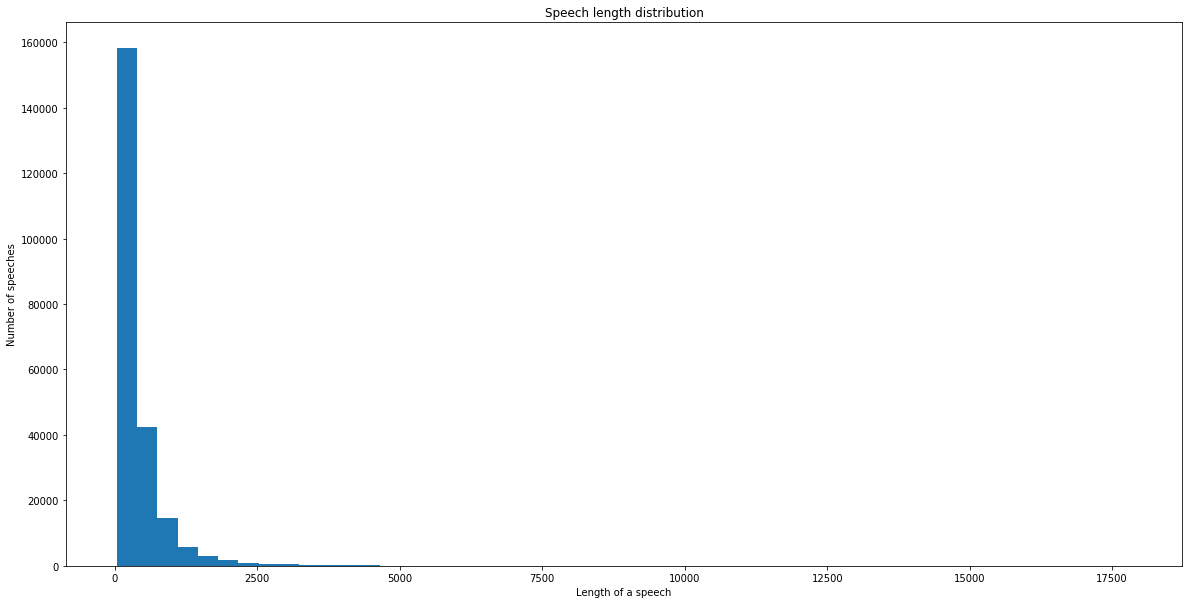

In [24]:
explore_data.plot_sample_length_distribution(train)

## CNN Models

### Pre-processing

In [25]:
# Limit on the number of features. 
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
# MAX_SEQUENCE_LENGTH = 100
MAX_SEQUENCE_LENGTH = 750

vec_params = {
    'num_words': TOP_K,
    'max_seq_length': MAX_SEQUENCE_LENGTH
}

In [26]:
start_time = time.time()
train_vec, val_vec, test_vec, word_index = preprocess_data.sequence_vectorize(train, val, test, **vec_params)
print("\nIt took {:.1f} seconds to tokenize the data".format(time.time()-start_time))


It took 197.2 seconds to tokenize the data


In [27]:
len(train), len(val), len(test)

(229048, 76348, 76352)

In [28]:
len(train_vec), len(val_vec), len(test_vec)

(229048, 76348, 76352)

In [29]:
max(map(max, train_vec)), max(map(max, val_vec)), max(map(max, test_vec))

(19999, 19999, 19999)

In [30]:
len(word_index)

568081

In [31]:
train_vec[0].shape

(750,)

In [32]:
train[2]

'Mr. President. I take a few minutes to make comments about a bill that I have been fooling around with for almost as many years as I have served in the Congress. I remember quite well when I was in the other body and served as chairman of the Fisheries Committee back in 1972. I hate to say how long it has been that we started working on the concept. over 20 years ago. to say that the fishing areas around the United States belong to the people of the United States. At that time. we were being literally inundated by foreign fishing fleets from Japan and other nations which saw the areas around the coastal waters of the entire United States off of our 30 coastal States as very valuable areas. They were coming in and really displacing our own American fishing men and women. and doing it at a rate that would have soon. I think. destroyed the areas of the United States as far as fisheries is concerned. We came up with the Fisheries Management Conservation Act. It was a very long and drawnou

In [33]:
train_vec[2][-10:]

array([  96, 3462,   66,    6,    7, 1152,   10,   87,    2,   96],
      dtype=int32)

In [34]:
for word in train[2].split()[-10:]:
    word = re.sub(r'[^\w\s]','',word).lower()
    print(word, word_index[word])

legislation 96
moves 3462
us 66
in 6
that 7
direction 1152
i 10
support 87
the 2
legislation 96


### Saving processed files

In [35]:
token_path = main_dir+'Classification/data/tokenized/age'

In [36]:
np.save(os.path.join(token_path, 'train_vec'), train_vec)
np.save(os.path.join(token_path, 'val_vec'), val_vec)
np.save(os.path.join(token_path, 'test_vec'), test_vec)

In [37]:
pickle.dump(word_index, open(os.path.join(token_path, 'word_index.p'), 'wb'))

In [38]:
train_vec = np.load(os.path.join(token_path, 'train_vec.npy'))
val_vec = np.load(os.path.join(token_path, 'val_vec.npy'))
test_vec = np.load(os.path.join(token_path, 'test_vec.npy'))

In [39]:
word_index = pickle.load(open(os.path.join(token_path, 'word_index.p'), 'rb'))

In [40]:
len(train_vec), len(val_vec), len(test_vec)

(229048, 76348, 76352)

## CNN model - Full Speech + Glove Embeddings

In [41]:
logs_base_dir = main_dir + 'Classification/logs/Age'

In [42]:
cnn_model_params = {
    'model': 'cnn',
    'word_index': word_index,
    'learning_rate': 0.001,
    'layers': 2,
    'epochs': 1000,
    'batch_size': 128,
    'filters': 64,
    'dropout_rate': 0.2,
    'embedding_dim': 200,
    'kernel_size': 5,
    'pool_size': 1,
    'max_num_words': 20000,
    'use_pretrained_embedding': True,
    'is_embedding_trainable': True,
    'glove_dir': main_dir + 'data'
}

In [43]:
gc.collect()

9

In [44]:
reload(train_model)
history, train_pred_probs, val_pred_probs = train_model.train_model(((train_vec, train_target), (val_vec, val_target)), logs_base_dir, **cnn_model_params)

Found 400000 word vectors.
It took 20.6 seconds
Preparing embedding matrix.
Embedding matrix has been built.
Its shape is (20000, 200).
It took 0.1 seconds
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 229048 samples, validate on 76348 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/1000
 - 2222s - loss: 0.6672 - acc: 0.5983 - val_loss: 0.6532 - val_acc: 0.6204
Epoch 2/1000
 - 2469s - loss: 0.6487 - acc: 0.6218 - val_loss: 0.6431 - val_acc: 0.6306
Epoch 3/1000
 - 2473s - loss: 0.6334 - acc: 0.6392 - val_loss: 0.6397 - val_acc: 0.6346
Epoch 4/1000
 - 2470s - loss: 0.6169 - acc: 0.6576 - val_loss: 0.6370 - val_acc: 0.6356
Epoch 5/1000
 - 2470s - loss: 0.5970 - acc: 0.6765 - val_loss: 0.6428 - val_acc: 0.6272
Epoch 6/1000
 - 2467s - loss: 0.5760 - a

### Clean up space/save outputs

In [45]:
probs_path = main_dir+'Classification/data/probs/age/'

In [46]:
np.save(probs_path+'val_pred_probs_cnn', val_pred_probs, allow_pickle=True, fix_imports=True)

In [47]:
val_pred_probs = np.load(probs_path+'val_pred_probs_cnn.npy', allow_pickle=True, fix_imports=True)

## Model Evaluation

In [48]:
val_preds = val_pred_probs > 0.5
np.mean(val_preds.flatten()==val_target)

0.6282941268926494

In [49]:
val_preds.shape, len(val_target)

((76348, 1), 76348)

Confusion matrix, without normalization
[[22506 15668]
 [12711 25463]]
             precision    recall  f1-score   support

        Old       0.64      0.59      0.61     38174
      Young       0.62      0.67      0.64     38174

avg / total       0.63      0.63      0.63     76348



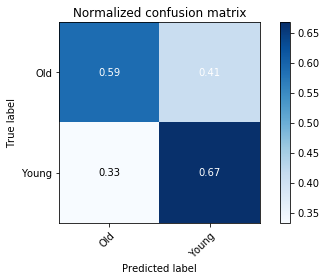

In [78]:
reload(explore_data)
# specify class names in 0 - 1 order
classes = ['Old', 'Young']
explore_data.plot_confusion_matrix(val_target, val_preds, classes, normalize=True)

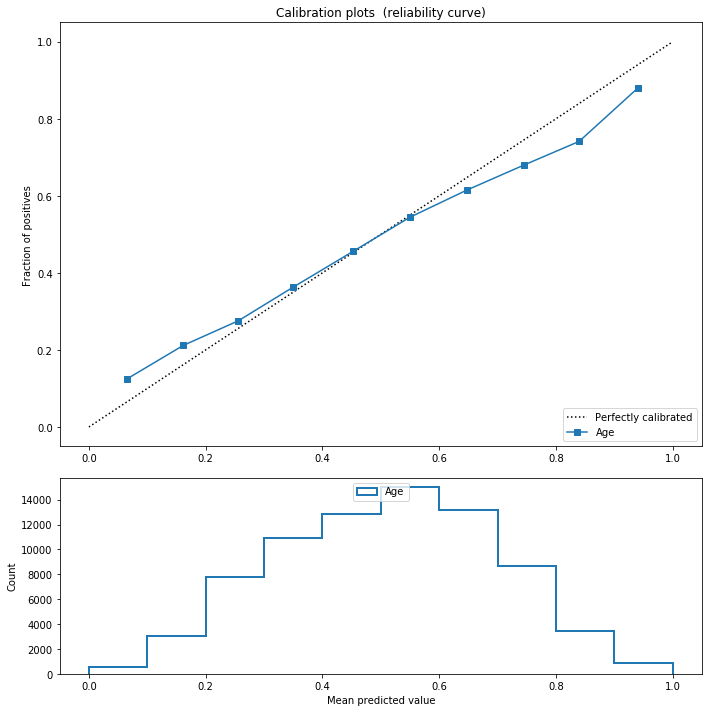

In [51]:
reload(explore_data)
explore_data.plot_calibration_curve(val_target, val_pred_probs, 'Age')

In [52]:
descr_df = pd.read_csv(main_dir+'data/QA/full_descr.txt', sep="|", index_col=0)
descr_df = descr_df.loc[np.asarray(val_ids, dtype=int)]
descr_df.shape

/home/yulia/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(80226, 16)

In [53]:
reload(explore_data)
# checking the ratios of demo variables in low-mid-high probability buckets
explore_data.check_bin_probs_distr(val_pred_probs, 
                                   val_ids, 
                                   descr_df)

Validation sample means:
      Gender_F  Ethinicity_NW     AvgAge   Party_D  Chamber_H  AvgWordCount
base  0.092015       0.096453  55.847655  0.523209   0.632962    380.291851


,Gender_F,Ethinicity_NW,AvgAge,Party_D,Chamber_H,AvgWordCount
0.4,0.76,0.75,1.07,1.02,0.39,0.98
0.6,1.07,1.07,1.00,1.03,1.08,1.01
1.0,1.12,1.13,0.94,0.95,1.42,1.00


In [54]:
reload(explore_data)
explore_data.compare_ngrams(val, val_pred_probs, ngram_range=(1, 2))


Top 10 ngrams by differentiating score:
mr president 	 2864.4
senator 	 2333.1
speaker 	 2321.3
mr speaker 	 2119.2
unanimous consent 	 2080.1
unanimous 	 2001.2
ask unanimous 	 1970.5
the gentleman 	 1909.7
president ask 	 1901.1
gentleman 	 1872.5


bin,1,2,3
ask unanimous,4102.0,2065.0,485.0
gentleman,1883.0,9724.0,15780.0
mr president,21416.0,11589.0,3865.0
mr speaker,5275.0,17124.0,26290.0
president ask,2508.0,680.0,147.0
senator,24481.0,11699.0,3770.0
speaker,6411.0,19958.0,30174.0
the gentleman,1637.0,9209.0,15228.0
unanimous,4933.0,2584.0,729.0
unanimous consent,4651.0,2336.0,588.0


In [55]:
reload(explore_data)
explore_data.print_mispredictions(val_target, val_pred_probs, val, val_ids, descr_df)


True positive (Predicted prob: 0.90):

date               20110218
char_count             1312
word_count              237
speakerid       1.12122e+08
Party                     R
Congress                112
Chamber                   H
State                    CO
Ethnicity                 W
Age                      56
Age_lt_med                1
NonWhite                  0
Female                    0
speaker          Mr. TIPTON
Full Name     TIPTON, SCOTT
match                 fuzzy
Name: 1120010754, dtype: object

 Mr. Speaker. I would like to stand and pay sincere tribute to the life of Seth King. Sadly the city of Pueblo. Colorado. will have to continue on without the talents and gifts of the revered local legend. Mr. King was a barber and clinical chemist by trade. but he represented much more to the Pueblo community. The owner and operator of Kings Barber shop. Seth King cut hair for 45 years and had a positive effect on the lives of countless individuals. Mr. King moved to Pueblo

## CNN - chunking the data

### Prepare the data

In [56]:
chunk_len=50

In [57]:
reload(preprocess_data)
start_time = time.time()
train_chunk, train_ids_chunk, train_target_chunk = preprocess_data.split_speech_to_chunks(train, train_ids, train_target, max_len=chunk_len)
val_chunk, val_ids_chunk, val_target_chunk = preprocess_data.split_speech_to_chunks(val, val_ids, val_target, max_len=chunk_len)
test_chunk, test_ids_chunk, test_target_chunk = preprocess_data.split_speech_to_chunks(test, test_ids, test_target, max_len=chunk_len)
print("\nIt took {:.1f} seconds to create the dictionary".format(time.time()-start_time))

Original data has 229048 speeches
It was split into 1852321 chunks
Checks on ids and target 1852321 1852321
Original target mean 0.5
New target mean 0.4941962003346072
Original data has 76348 speeches
It was split into 617897 chunks
Checks on ids and target 617897 617897
Original target mean 0.5
New target mean 0.49627850596458634
Original data has 76352 speeches
It was split into 610677 chunks
Checks on ids and target 610677 610677
Original target mean 0.5
New target mean 0.4935931760980027

It took 27.7 seconds to create the dictionary


In [58]:
# Limit on the number of features. 
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
# MAX_SEQUENCE_LENGTH = 100
MAX_SEQUENCE_LENGTH = chunk_len

vec_params = {
    'num_words': TOP_K,
    'max_seq_length': MAX_SEQUENCE_LENGTH
}

In [59]:
start_time = time.time()
train_vec, val_vec, test_vec, word_index = preprocess_data.sequence_vectorize(train_chunk, val_chunk, test_chunk, **vec_params)
print("\nIt took {:.1f} seconds to tokenize the data".format(time.time()-start_time))


It took 441.1 seconds to tokenize the data


In [60]:
np.save(os.path.join(token_path, 'train_vec_chunk'), train_vec)
np.save(os.path.join(token_path, 'val_vec_chunk'), val_vec)
np.save(os.path.join(token_path, 'test_vec_chunk'), test_vec)

In [61]:
train_vec = np.load(os.path.join(token_path, 'train_vec_chunk.npy'))
val_vec = np.load(os.path.join(token_path, 'val_vec_chunk.npy'))
test_vec = np.load(os.path.join(token_path, 'test_vec_chunk.npy'))

In [62]:
train_vec.shape

(1852321, 50)

In [63]:
train_vec[0]

array([   26,   112,    10,   103,     3,   178,    26,     1,    12,
        1044,   381,    11,   128,    59,    46,    27,    47,   975,
         644,     6,   164,   916,    25,     2,   445,   586,  2306,
        2586,  5996,   736,  1076,     2,  2933,     5, 11732,     4,
           2,     1,     2,     1,  3847,    29,  2419,  1189,     5,
        1603,     6,  1222,   195,     2], dtype=int32)

In [64]:
type(train_vec)

numpy.ndarray

### Run the model

In [65]:
history_chunk, train_pred_probs_chunk, val_pred_probs_chunk = train_model.train_model(((train_vec, train_target_chunk), (val_vec, val_target_chunk)), logs_base_dir, **cnn_model_params)

Found 400000 word vectors.
It took 36.0 seconds
Preparing embedding matrix.
Embedding matrix has been built.
Its shape is (20000, 200).
It took 0.1 seconds
Train on 1852321 samples, validate on 617897 samples
Epoch 1/1000
 - 1658s - loss: 0.6776 - acc: 0.5668 - val_loss: 0.6732 - val_acc: 0.5775
Epoch 2/1000
 - 1137s - loss: 0.6658 - acc: 0.5913 - val_loss: 0.6729 - val_acc: 0.5783
Epoch 3/1000
 - 1050s - loss: 0.6592 - acc: 0.6020 - val_loss: 0.6719 - val_acc: 0.5791
Epoch 4/1000
 - 1050s - loss: 0.6526 - acc: 0.6118 - val_loss: 0.6740 - val_acc: 0.5773
Epoch 5/1000
 - 1053s - loss: 0.6454 - acc: 0.6211 - val_loss: 0.6756 - val_acc: 0.5754
Validation accuracy: 0.5754292607307434, loss: 0.6756157020758051


In [79]:
np.save(probs_path+'val_pred_probs_cnn_chunk', val_pred_probs_chunk, allow_pickle=True, fix_imports=True)

In [92]:
val_preds_chunk = val_pred_probs_chunk > 0.5
np.mean(val_preds_chunk.flatten()==val_target_chunk)

0.5754292382063677

In [68]:
pred_df = pd.DataFrame({'ids': val_ids_chunk, 'target': val_target_chunk, 'probs': val_pred_probs_chunk.flatten(), 'preds': val_preds_chunk.flatten()})
f = {'probs': [min, max, 'mean']}
pred_aggr_df = pred_df.groupby('ids').agg(f).reset_index()
pred_aggr_df.columns = ['ids', 'probs_min', 'probs_max', 'probs_mean']
pred_aggr_df = pred_aggr_df.merge(pred_df[['target', 'ids']].groupby('ids').mean().reset_index(), on='ids')
pred_aggr_df = pred_aggr_df.merge(pred_df[['preds', 'ids']].groupby('ids').mean().reset_index(), on='ids')
pred_aggr_df['preds_probs_mean'] = pred_aggr_df['probs_mean'].apply(lambda x: 1 if x > 0.5 else 0)
pred_aggr_df['preds_mean'] = pred_aggr_df['preds'].apply(lambda x: 1 if x > 0.5 else 0)
pred_aggr_df.head()

,ids,probs_min,probs_max,probs_mean,target,preds,preds_probs_mean,preds_mean
0,1000000059,0.487635,0.691196,0.601263,0,0.888889,1,1
1,1000000124,0.451890,0.544882,0.492063,1,0.333333,0,0
2,1000000354,0.428326,0.577475,0.500335,1,0.500000,1,0
3,1000000360,0.045549,0.723934,0.443347,0,0.305556,0,0
4,1000000452,0.431620,0.532566,0.482093,0,0.500000,0,0


In [69]:
np.mean(pred_aggr_df.target == pred_aggr_df.preds_probs_mean), np.mean(pred_aggr_df.target == pred_aggr_df.preds_mean)

(0.6363493477235815, 0.6309922984230104)

In [90]:
original_df = pd.DataFrame({'target_orig': val_target, 'ids': val_ids})
original_df = original_df.merge(pred_aggr_df, on="ids")
original_df.head()

,target_orig,ids,probs_min,probs_max,probs_mean,target,preds,preds_probs_mean,preds_mean
0,1,1060162543,0.476404,0.665580,0.570992,1,0.500000,1,0
1,1,980236360,0.400324,0.828363,0.572081,1,0.739130,1,1
2,1,990257551,0.309233,0.472752,0.410642,1,0.000000,0,0
3,1,1010233637,0.424273,0.670593,0.551683,1,0.642857,1,1
4,1,980084907,0.309678,0.603649,0.435199,1,0.142857,0,0


In [89]:
original_df.target_orig.sum(), original_df.target.sum()

(38174, 38174)

## Model evaluation

In [98]:
val_pred_aggr_chunk = original_df.preds_probs_mean
val_pred_probs_aggr_chunk = original_df.probs_mean
# val_aggr_target = pred_aggr_df.target
# val_aggr_ids = pred_aggr_df.ids

In [101]:
np.save(probs_path+'val_pred_probs_cnn_aggr_chunk', val_pred_probs_aggr_chunk, allow_pickle=True, fix_imports=True)

Confusion matrix, without normalization
[[19787 18387]
 [ 9377 28797]]
             precision    recall  f1-score   support

        Old       0.68      0.52      0.59     38174
      Young       0.61      0.75      0.67     38174

avg / total       0.64      0.64      0.63     76348



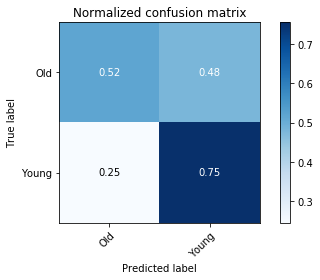

In [99]:
reload(explore_data)
# specify class names in 0 - 1 order
explore_data.plot_confusion_matrix(val_target, val_pred_aggr_chunk, classes, normalize=True)

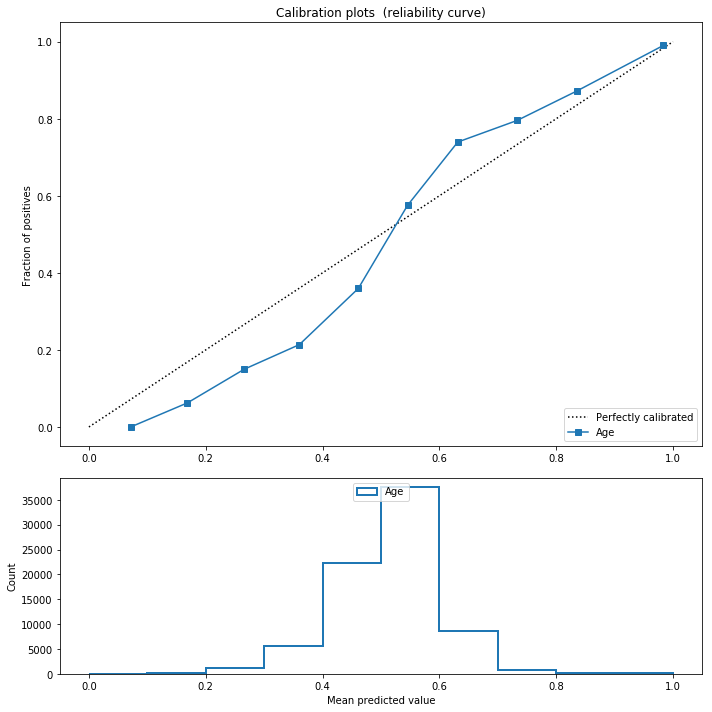

In [100]:
reload(explore_data)
explore_data.plot_calibration_curve(val_target, val_pred_probs_aggr_chunk, 'Age')

In [74]:
reload(explore_data)
# checking the ratios of demo variables in low-mid-high probability buckets
explore_data.check_bin_probs_distr(val_pred_probs_aggr_chunk, 
                                   val_aggr_ids, 
                                   descr_df)

Validation sample means:
      Gender_F  Ethinicity_NW     AvgAge   Party_D  Chamber_H  AvgWordCount
base  0.092015       0.096453  55.847655  0.523209   0.632962    380.291851


,Gender_F,Ethinicity_NW,AvgAge,Party_D,Chamber_H,AvgWordCount
0.4,0.44,0.61,1.11,0.96,0.13,0.34
0.6,1.06,1.04,1.00,1.03,1.02,1.13
1.0,1.03,1.03,0.91,0.87,1.46,0.66


In [75]:
reload(explore_data)
explore_data.compare_ngrams(val_chunk, val_pred_probs_chunk, ngram_range=(1, 2))


Top 10 ngrams by differentiating score:
mr president 	 14003.0
senator 	 12471.1
senate 	 11635.4
the senate 	 10399.3
speaker 	 9501.8
president 	 8979.3
mr speaker 	 8370.5
senators 	 5346.5
gentleman 	 5174.0
the gentleman 	 5168.5


bin,1,2,3
gentleman,437.0,13321.0,13629.0
mr president,14386.0,20006.0,2144.0
mr speaker,1428.0,25559.0,21338.0
president,21361.0,46009.0,8504.0
senate,14113.0,18925.0,1697.0
senator,17880.0,20439.0,1631.0
senators,4284.0,3870.0,257.0
speaker,1806.0,29934.0,24803.0
the gentleman,360.0,12338.0,13037.0
the senate,11547.0,15049.0,1192.0


In [76]:
reload(explore_data)
explore_data.compare_ngrams(val, val_pred_probs_aggr_chunk, ngram_range=(1, 2))


Top 10 ngrams by differentiating score:
sitting right 	 26.3
certainly also 	 20.3
plus in 	 20.2
support paid 	 19.6
been substantial 	 18.8
doing bad 	 17.8
tradein 	 17.4
practical problem 	 17.4
strategy by 	 17.4
were pending 	 17.1


bin,1,2,3
been substantial,9.0,6.0,4.0
certainly also,5.0,1.0,0.0
doing bad,1.0,0.0,6.0
plus in,7.0,4.0,0.0
practical problem,0.0,0.0,5.0
sitting right,9.0,5.0,0.0
strategy by,7.0,3.0,4.0
support paid,6.0,1.0,0.0
tradein,0.0,0.0,5.0
were pending,7.0,4.0,0.0
